## Setup and data loading

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0, EfficientNetB4, InceptionV3, EfficientNetV2S

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 100


In [2]:
dataset_name = "cifar100"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

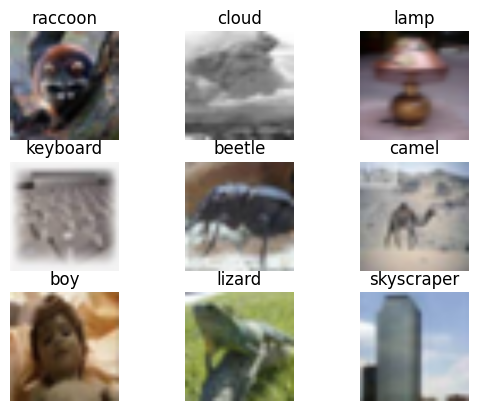

In [4]:

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [5]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


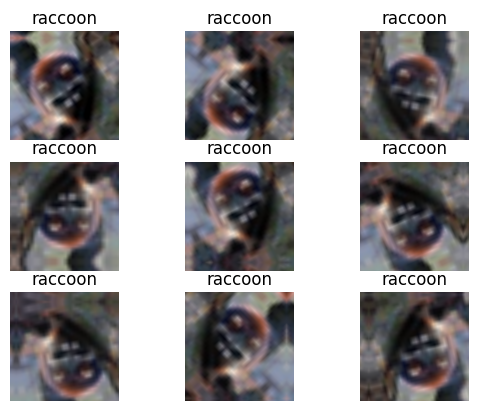

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [7]:

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)


## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [ ]:
# logdir = '/tmp/logdir'

# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 10 # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train,
                 epochs=epochs,
                 validation_data=ds_test
                 )


Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization[0

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=/tmp/logdir

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [ ]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)